In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# perla sami younane 320220028
# nihal ahmed adly 320220039

In [18]:
def load_wisdm_raw(path):
    data = []
    with open(path) as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) < 6:
                continue
            try:
                activity = parts[0].strip()
                user = int(parts[1].strip())
                timestamp = int(parts[2].strip())
                x = float(parts[3].strip())
                y = float(parts[4].strip())
                z = float(parts[5].replace(';', '').strip())
                data.append([user, activity, timestamp, x, y, z])
            except:
                continue

    df = pd.DataFrame(data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])
    return df


In [19]:
df = load_wisdm_raw("/content/WISDM_ar_v1.1_raw.txt")


In [21]:
with open("/content/WISDM_ar_v1.1_raw.txt") as f:
    for _ in range(10):
        print(f.readline())


33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;

33,Jogging,49106062271000,5.012288,11.264028,0.95342433;

33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;

33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;

33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;

33,Jogging,49106442306000,1.3756552,-2.4925237,-6.510526;

33,Jogging,49106542312000,-0.61291564,10.56939,5.706926;

33,Jogging,49106652389000,-0.50395286,13.947236,7.0553403;

33,Jogging,49106762313000,-8.430995,11.413852,5.134871;

33,Jogging,49106872299000,0.95342433,1.3756552,1.6480621;



In [23]:
import pandas as pd

# Read the file line by line and clean it
data = []
with open("/content/WISDM_ar_v1.1_raw.txt") as file:
    for line in file:
        # Remove semicolon and strip whitespaces
        line = line.strip().strip(';')
        # Split only if the line has exactly 6 fields
        parts = line.split(',')
        if len(parts) == 6:
            user, activity, timestamp, x, y, z = parts
            # Check if any of x, y, z are empty strings before converting
            if x.strip() and y.strip() and z.strip():
                try:
                    data.append([int(user), activity, int(timestamp), float(x), float(y), float(z)])
                except ValueError:
                    # Handle cases where conversion fails even if strings are not empty
                    print(f"Skipping line: {line}")
            else:
                print(f"Skipping line with missing values: {line}")

# Convert to DataFrame
df = pd.DataFrame(data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

# Check the distribution of activities now
print(df['activity'].value_counts())

Skipping line with missing values: 11,Walking,1867172313000,4.4,4.4,
activity
Walking       418393
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: count, dtype: int64


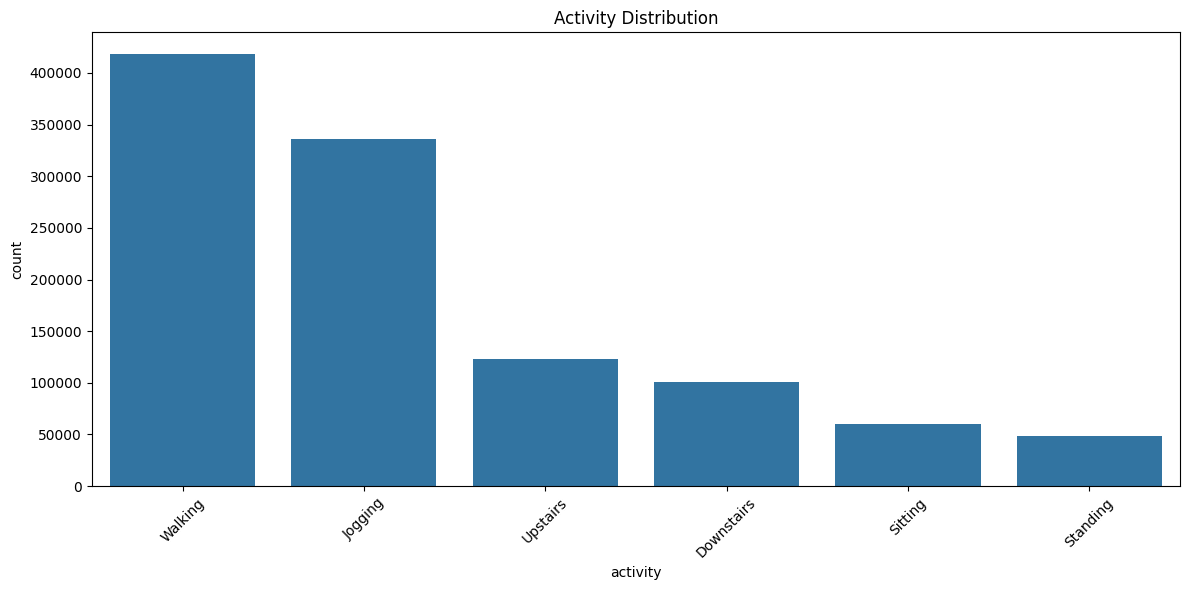

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='activity', order=df['activity'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Activity Distribution")
plt.tight_layout()
plt.show()


In [26]:
def create_segments(data, window_size=200, step=20):
    segments, labels = [], []

    for i in range(0, len(data) - window_size, step):
        xs = data['x'].values[i: i + window_size]
        ys = data['y'].values[i: i + window_size]
        zs = data['z'].values[i: i + window_size]
        label_window = data['activity'].values[i: i + window_size]
        label = label_window[window_size // 2]

        segments.append([xs, ys, zs])
        labels.append(label)

    return np.array(segments).transpose(0, 2, 1), np.array(labels)

segments, labels = create_segments(df, window_size=200, step=40)

# Encode labels
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
labels_cat = to_categorical(labels_enc)

# Split
X_train, X_test, y_train, y_test = train_test_split(segments, labels_cat, test_size=0.2, random_state=42)

print("Segments shape:", segments.shape)
print("Labels shape:", labels_cat.shape)


Segments shape: (27157, 200, 3)
Labels shape: (27157, 6)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(200, 3)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 102s 283ms/step - accuracy: 0.6275 - loss: 1.0800 - val_accuracy: 0.7800 - val_loss: 0.6079
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 131s 252ms/step - accuracy: 0.8053 - loss: 0.5584 - val_accuracy: 0.8301 - val_loss: 0.4338
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 148s 269ms/step - accuracy: 0.8266 - loss: 0.4628 - val_accuracy: 0.8721 - val_loss: 0.3351
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 139s 260ms/step - accuracy: 0.8708 - loss: 0.3416 - val_accuracy: 0.8608 - val_loss: 0.3280
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 146s 272ms/step - accuracy: 0.8892 - loss: 0.2973 - val_accuracy: 0.8864 - val_loss: 0.2987
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 90s 265ms/step - accuracy: 0.9119 - loss: 0.2544 - val_accuracy: 0.9236 - val_loss: 0.2078
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 269ms/step - accuracy: 0.9211 - loss: 0.2246 - val_accuracy: 0.9374 - val_loss: 0.1669
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 273ms/step - accuracy: 0.9446 - 

In [28]:
# Accuracy
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step
Accuracy: 0.9525036818851251
              precision    recall  f1-score   support

  Downstairs       0.87      0.76      0.81       496
     Jogging       0.99      0.99      0.99      1699
     Sitting       0.99      0.92      0.96       300
    Standing       0.92      0.98      0.95       238
    Upstairs       0.86      0.87      0.86       647
     Walking       0.97      0.99      0.98      2052

    accuracy                           0.95      5432
   macro avg       0.93      0.92      0.93      5432
weighted avg       0.95      0.95      0.95      5432



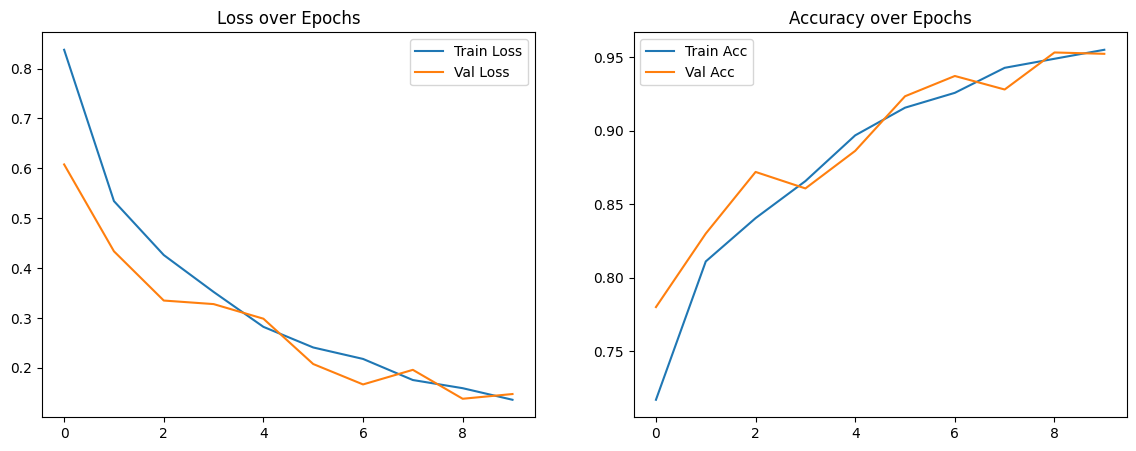

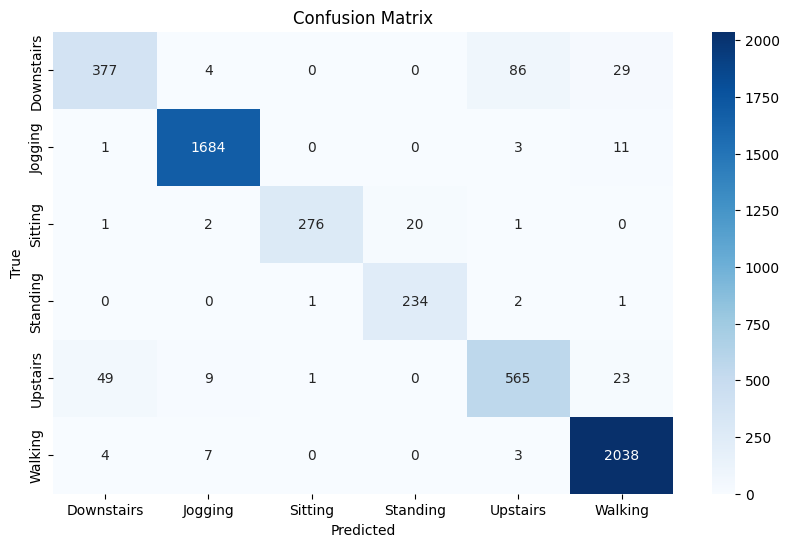

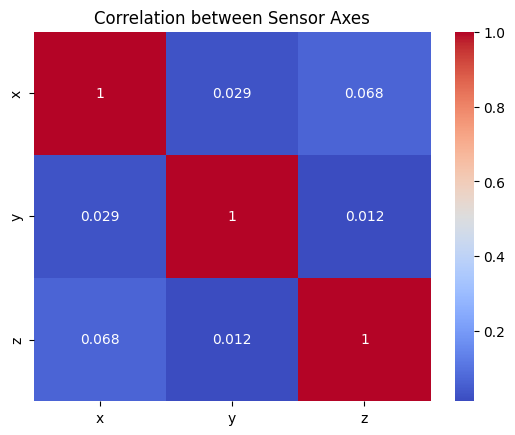

In [29]:
# Loss/Accuracy curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Correlation heatmap between sensors
sensor_df = df[['x', 'y', 'z']]
corr = sensor_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Sensor Axes")
plt.show()


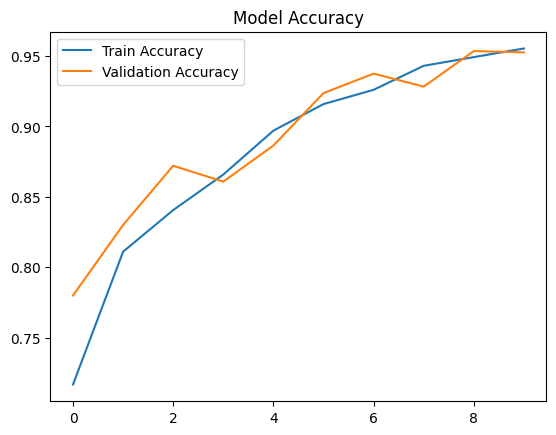

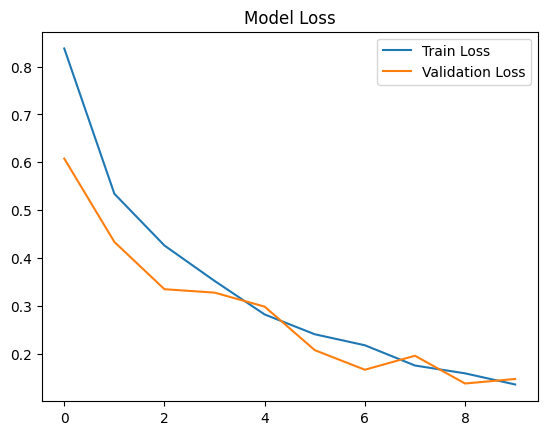

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()
